In [1]:
#Needed in general


import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5
import gc

#Quick fudge to make import from ../Scripts work
sys.path.append('../Scripts')

#Custom imports
# import ClassCOMPAS     as CC ###
# import ClassFormationChannels as FC a


# import script that has formation channel classification functions:
from PostProcessingScripts import * 
# from ClassFormationChannels_5mainchannels import * 



from astropy import units as u
from astropy import constants as const

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# print(fs)

import astropy
import seaborn as sns
# from seaborn_utility import cmap_from_colour

from astropy import units as u
from astropy import constants as c

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])



In [10]:






def plot_Fig_GWTC(axe='None', xparam='chiEff', BPSmodelName='A', mssfr='112', spin_threshold=0.05, hack=None):
    
    colors = ['#1f77b4', '#ff7f0e']
    colors_lighter = [adjust_lightness(color=colors[0], amount=2.2),adjust_lightness(color=colors[1], amount=1.7)]

    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    
    fdata = h5.File(path, 'r')
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1
    
    seedsDCO  = fdata['doubleCompactObjects']['seed'][...].squeeze()  # get the seeds in the DCO file 
    seedsSN   = fdata['supernovae']['randomSeed'][...].squeeze()    # get the seeds in the SN file 
    indices   = np.sort(np.unique(seedsSN[1::2], return_index=True)[1])
    maskSNdco = np.in1d(seedsSN,  seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
    whichSN   = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]  # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova     
    whichSN2  = whichSN[1::2][indices]

    # either SN2 = primary (1) and M1 is > M2, or SN2 = secondary & M1 < M2 
    # this takes into account (first term) rejuvenation 
    mask_MRR = ((whichSN2==1) & (massCO_ZAMSM1>massCO_ZAMSM2) ) | ((whichSN2==2) & (massCO_ZAMSM1<massCO_ZAMSM2)) 

#     del massCO_ZAMSM1
#     del massCO_ZAMSM2
    del whichSN2
    del whichSN
    del maskSNdco
    del indices
    del seedsSN
    del seedsDCO


    spin = COspin(data_path=path, state='he_depletion')  # set class 
    spin.setCOMPASData() # reads in the COMPAS DCO parameters 
    spinZAMSM1, spinZAMSM2  = spin.BaveraSpin() #ZAMS M1 SPIN 

    spinLVKM1, spinLVKM2 = np.zeros_like(spinZAMSM1), np.zeros_like(spinZAMSM1)
    spinLVKM1[mask_MRR] = spinZAMSM2[mask_MRR]  # MRR so M1 comes from M2ZAMS, we assign it spin from M2ZAMS
    spinLVKM1[~mask_MRR] = spinZAMSM1[~mask_MRR]  # no MRR so M1 comes from M1ZAMS, we assign it spin from M1ZAMS
    spinLVKM2[mask_MRR] = spinZAMSM1[mask_MRR]   # MRR so M2 comes from M1ZAMS, we assign it spin from M1ZAMS
    spinLVKM2[~mask_MRR] = spinZAMSM2[~mask_MRR]   # no MRR so M2 comes from M2ZAMS, we assign it spin from M2ZAMS     

    # spin_threshold = 0.05 # definition of "spinning BH"
    mask_LVKM1_spinning = (spinLVKM1 > spin_threshold ) 
    mask_LVKM2_spinning = (spinLVKM2 > spin_threshold ) # definition of "spinning BH"
    mask_anySpin = (spinLVKM1 > spin_threshold ) | (spinLVKM2 > spin_threshold )    

    print('\t non-zero spin:', np.sum(mask_anySpin), 'out of ', len(mask_anySpin), 'BBHs')

    
    ### read in MSSFR weights: ###
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    weights_ = fdata[fparam_key][weightheader][...].squeeze()
    w = weights_
    
    fs_l = 20 # label fontsize
    


    if xparam=='ChiEff_vs_q':
        axe.set_xlim(-0.06, 1.05)
        axe.set_ylim(0, 1)  
        chi_eff = ((spinZAMSM1 * massCO_ZAMSM1) + spinZAMSM2 * massCO_ZAMSM2) / (massCO_ZAMSM1+massCO_ZAMSM2)
        param_x = chi_eff
        param_y = MassRatioCO_LVK
        nameX = r'$\chi_{\rm{eff}}$'
        nameY = r'$q$'
 
        
    NN_ = 100
    mask_nonZero = (chi_eff>0.1)
    print(chi_eff[mask_nonZero])
    size_ = 500
    
    
    if hack=='chi_eff':
        axe.hist(param_x[~mask_MRR][:], bins=100, color=colors_lighter[0], weights=w[~mask_MRR][:], zorder=1, label=r'no MRR', density=True, histtype='step') # all non MRR 
        axe.hist(param_x[mask_MRR][:],  bins=100, color=colors[1],         weights=w[mask_MRR][:],  zorder=2, label=r'MRR: $q < 1$', density=True, histtype='step') # all non MRR 
        
    elif hack=='q':
        axe.hist(param_y[~mask_MRR][:NN_], bins=30, color=colors_lighter[0], weights=w[~mask_MRR][:NN_], zorder=1, label=r'no MRR', density=True, histtype='step') # all non MRR 
        axe.hist(param_y[mask_MRR][:NN_],  bins=30, color=colors[1],         weights=w[mask_MRR][:NN_],  zorder=2, label=r'MRR: $q < 1$', density=True, histtype='step') # all non MRR 
        
    
    else:
#         axe.scatter(param_x[~mask_MRR][:NN_], param_y[~mask_MRR][:NN_], s=size_*w[~mask_MRR][:NN_], color=colors_lighter[0], zorder=1, label=r'no MRR') # all non MRR 
#         axe.scatter(param_x[mask_MRR][:NN_], param_y[mask_MRR][:NN_], s=size_*w[mask_MRR][:NN_], color=colors[1], zorder=2, label=r'MRR: $q < 1$') # all non MRR 
        axe.scatter(param_x[~mask_MRR][:], param_y[~mask_MRR][:], s=size_*w[~mask_MRR][:], color=colors_lighter[0], zorder=1, label=r'no MRR') # all non MRR 
        axe.scatter(param_x[mask_MRR][:], param_y[mask_MRR][:], s=size_*w[mask_MRR][:], color=colors[1], zorder=2, label=r'MRR') # all non MRR 


    axe.grid(True)
    
    if BPSmodelName=='A':
        axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l)
    else:
        axe = layoutAxesNoYlabel(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l)

        for tick in axe.yaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
            tick.label1.set_visible(False)
            tick.label2.set_visible(False)


    
    
    axe.text(0+0.009, 0.009, r'\textbf{model %s} %s'%(BPSmodelName,alphabetPhysicalNameDict[BPSmodelName]) , rotation = 0, fontsize = fs-2, color = 'k', ha = 'left', va='bottom', transform=axe.transAxes, zorder=100)#, weight = 'bold')
    
#     plt.legend(fontsize=fs_l, loc=3)
    
    
  
    
    return axe 









0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
	 non-zero spin: 5411751 out of  8782290 BBHs
[0.32253369 0.2247504  0.14384706 ... 0.1041578  0.10614085 0.10242344]


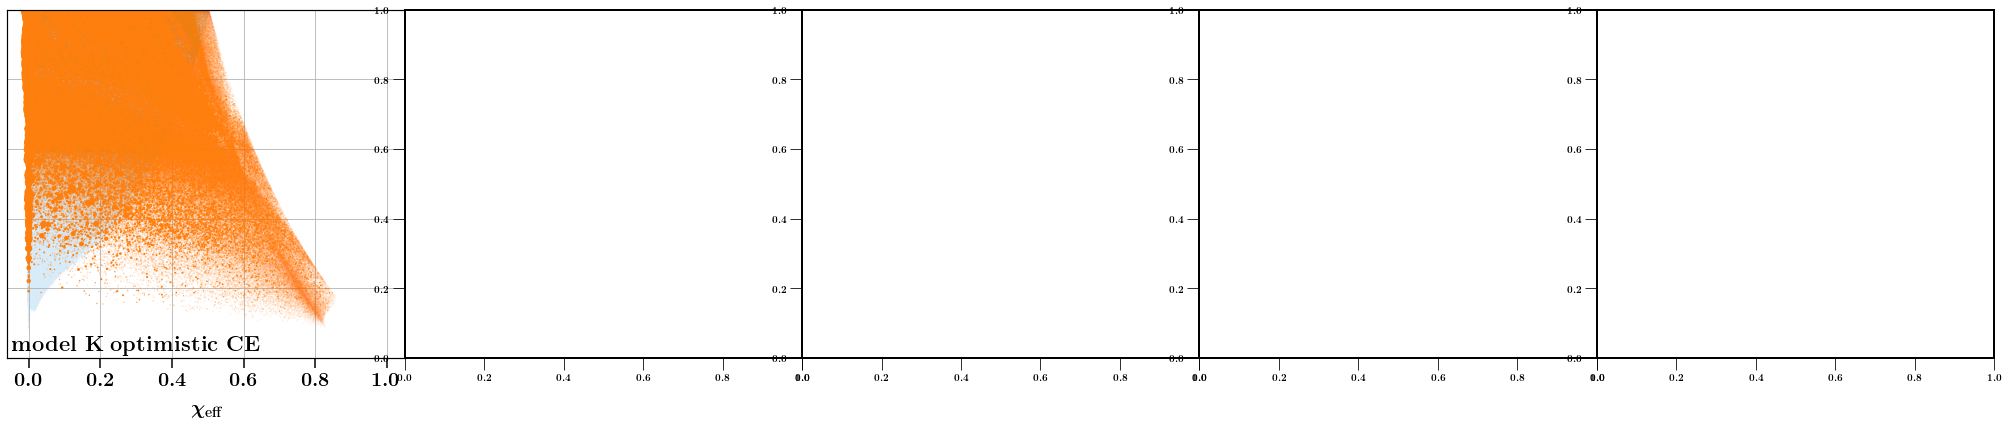

In [8]:



fig, ax = plt.subplots(1,5, figsize=(28,6))#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
xparam='ChiEff_vs_q'

# for ax_ind, model in enumerate(['A', 'G', 'J', 'K', 'R']):
for ax_ind, model in enumerate([ 'K']):
    ax[ax_ind] = plot_Fig_GWTC(axe=ax[ax_ind], xparam='ChiEff_vs_q', BPSmodelName=model, mssfr=mssfr)
    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


# plt.savefig('./' + xparam + '_' + mssfr   +  '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show()  

0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
	 non-zero spin: 5411751 out of  8782290 BBHs
[0.32253369 0.2247504  0.14384706 ... 0.1041578  0.10614085 0.10242344]
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
	 non-zero spin: 5411751 out of  8782290 BBHs
[0.32253369 0.2247504  0.14384706 ... 0.1041578  0.10614085 0.10242344]


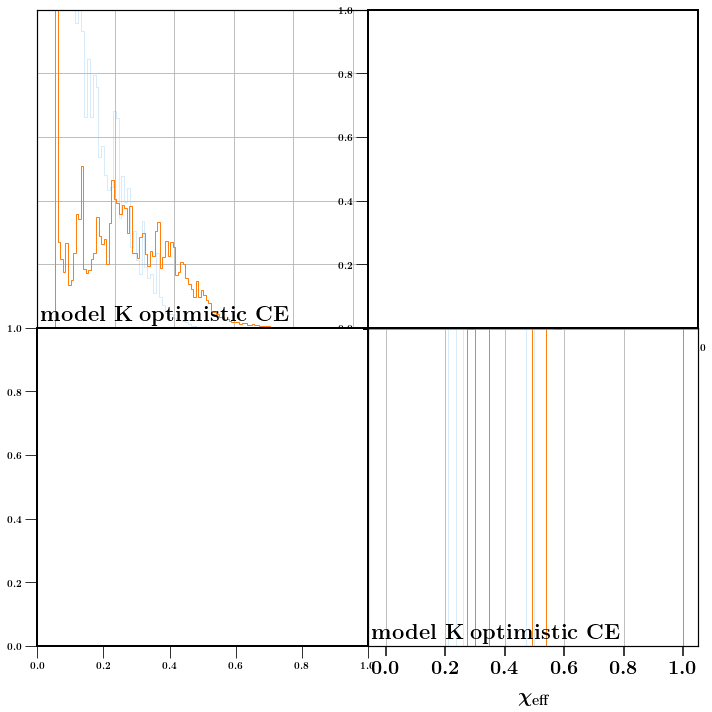

In [11]:



fig, ax = plt.subplots(2,2, figsize=(10,10))#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
xparam='ChiEff_vs_q'

# for ax_ind, model in enumerate(['A', 'G', 'J', 'K', 'R']):
model = 'K'
    
ax[0,0] = plot_Fig_GWTC(axe=ax[0,0], xparam='ChiEff_vs_q', BPSmodelName=model, mssfr=mssfr, hack='chi_eff')

# ax[0,1] = plot_Fig_GWTC(axe=ax[0,1], xparam='ChiEff_vs_q', BPSmodelName=model, mssfr=mssfr)
ax[1,1] = plot_Fig_GWTC(axe=ax[1,1], xparam='ChiEff_vs_q', BPSmodelName=model, mssfr=mssfr, hack='q')
ax[1,1].set_yscale('log')


plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


# plt.savefig('./' + xparam + '_' + mssfr   +  '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show()  

In [ ]:




def plot_PDFs(axe='None', xparam='chiEff', BPSmodelName='A', mssfr='112'):
    
#     labellist= np.ones(5) #,  r'$\log_{10}(t) $']      

    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    
    color_ = 'crimson'
    
    # read in data 
    fdata = h5.File(path)
    
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1


        
    spin = COspin(data_path=path, state='he_depletion')  # set class 
    spin.setCOMPASData() # reads in the COMPAS DCO parameters 
    spinZAMSM1, spinZAMSM2  = spin.BaveraSpin() #ZAMS M1 SPIN 
    
    
    maxSpinBBH = np.maximum(spinZAMSM1,spinZAMSM2)
    mask_ = (maxSpinBBH >0)
    print('\t non-zero spin:', np.sum(mask_), 'out of ', len(mask_), 'BBHs')
    mask_ = (maxSpinBBH >0.2)
    print('\t a spin >.2: ', np.sum(mask_), 'out of ', len(mask_), 'BBHs')
    
    mask_MRR = (massCO_ZAMSM1/massCO_ZAMSM2) < 1
#     mask_muchMRR = (massCO_ZAMSM1/massCO_ZAMSM2) < 0.9  

    
    ### read in MSSFR weights: ###
    fparam_key = 'weights_detected'
    for ind_mssfr, mssfr in enumerate(MSSFRnameslist[:]):
        weightheader = 'w_' + mssfr
        weights_ = fdata[fparam_key][weightheader][...].squeeze()
        w = weights_



        fs_l = 20 # label fontsize



        if xparam=='ChiEff':
            axe.set_xlim(-0.06, 1.05)
            axe.set_ylim(0, 1.1)  
            chi_eff = ((spinZAMSM1 *massCO_ZAMSM1) + spinZAMSM2*massCO_ZAMSM2) / (massCO_ZAMSM1+massCO_ZAMSM2)
            param_x = chi_eff

            nameX = r'$\chi_{\rm{eff}}$'
            nameY = r'\textbf{PDF}'


        NN_ = 100
        mask_nonZero = (chi_eff>0.1)
        print(chi_eff[mask_nonZero])
        size_ = 1000



        # Compute a weighted estimate on the same grid, using verbose API
    #     x = np.linspace(0,1,100)
    #     estimator = FFTKDE(kernel='biweight', bw='silverman')
    #     y2 = estimator.fit(param_x[~mask_MRR], weights=weights_[~mask_MRR]).evaluate(x)
    #     plt.plot(x, y2, color='crimson')

        nbins = np.linspace(0,1,25)
        axe.hist(param_x, bins=nbins, color='k', zorder=2, label=r'All BBHs', weights=weights_, density=True, histtype='step')
        axe.hist(param_x[~mask_MRR], bins=nbins, color='mediumseagreen', zorder=3, label=r'not MRR', weights=weights_[~mask_MRR], density=True, histtype='step')
        axe.hist(param_x[mask_MRR], bins=nbins, color='crimson', zorder=3, label=r'MRR', weights=weights_[mask_MRR], density=True, histtype='step')
    #     axe.scatter(param_x[~mask_MRR][:NN_], param_y[~mask_MRR][:NN_], s=size_*w[~mask_MRR][:NN_], color='lightgray', zorder=1, label=r'no MRR') # all non MRR 
    #     axe.scatter(param_x[mask_MRR][:NN_], param_y[mask_MRR][:NN_], s=size_*w[mask_MRR][:NN_], color='crimson', zorder=2, label=r'MRR: $q < 1$') # all non MRR 
    #     axe.scatter(param_x[~mask_MRR][:], param_y[~mask_MRR][:], s=size_*w[~mask_MRR][:], color='lightgray', zorder=1, label=r'no MRR') # all non MRR 
    #     axe.scatter(param_x[mask_MRR][:], param_y[mask_MRR][:], s=size_*w[mask_MRR][:], color='crimson', zorder=2, label=r'MRR') # all non MRR 


    axe.grid(True)
    
    if BPSmodelName=='A':
        axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l)
    else:
        axe = layoutAxesNoYlabel(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l)

        for tick in axe.yaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
            tick.label1.set_visible(False)
            tick.label2.set_visible(False)


    
    
    axe.text(1-0.009, 1-0.009, r'\textbf{model %s} %s'%(BPSmodelName,alphabetPhysicalNameDict[BPSmodelName]) , rotation = 0, fontsize = fs-2, color = 'k', ha = 'right', va='top', transform=axe.transAxes, zorder=100)#, weight = 'bold')
    
#     plt.legend(fontsize=fs_l, loc=3)
    
    
  
    
    return axe 









In [ ]:



fig, ax = plt.subplots(1,5, figsize=(28,6))#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
xparam='ChiEff'

for ax_ind, model in enumerate(['A', 'G', 'J', 'K', 'R']):
    ax[ax_ind] = plot_PDFs(axe=ax[ax_ind], xparam='ChiEff', BPSmodelName=model, mssfr=mssfr)
    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '.eps', transparent=False, bbox_inches="tight", dpi=600, format='eps')
plt.show()  